<a href="https://www.kaggle.com/code/andrey36912/notebooka17406bab3?scriptVersionId=192790031" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [157]:
import numpy as np
import pandas as pd
import os
from PIL import Image



In [158]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.utils.data import DataLoader, random_split

In [159]:
data_dir = '/kaggle/input/fruit-recognition/train/train'
dataset = datasets.ImageFolder(root=data_dir)
len(dataset)

16854

In [160]:
dataset.classes

['Apple Braeburn',
 'Apple Granny Smith',
 'Apricot',
 'Avocado',
 'Banana',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe',
 'Cherry',
 'Clementine',
 'Corn',
 'Cucumber Ripe',
 'Grape Blue',
 'Kiwi',
 'Lemon',
 'Limes',
 'Mango',
 'Onion White',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Pear',
 'Pepper Green',
 'Pepper Red',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Potato Red',
 'Raspberry',
 'Strawberry',
 'Tomato',
 'Watermelon']

In [161]:

from torch.utils.data import random_split

train_ratio = 0.8


train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [162]:
len(train_data), len(val_data)

(13484, 3370)

In [163]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(),  
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(), 
])


train_data = datasets.ImageFolder(root=data_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=data_dir, transform=test_transform)

In [164]:
class ImageDataset(torch.utils.data.Dataset):
   
    def __init__(self, root_dir, transform=None):
       
        self.root_dir = root_dir
        self.image_paths, self.labels = self.get_paths_and_labels()
        self.transform = transform

    def get_paths_and_labels(self):
        image_paths = []
        labels = []
        for label in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    image_paths.append(img_path)
                    labels.append(label)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label_name = self.labels[idx]
        label = 0 if label_name == 'all' else 1  
        if self.transform:
            image = self.transform(image)
        return image, label

In [165]:
os.listdir(data_dir)

['Orange',
 'Tomato',
 'Passion Fruit',
 'Cucumber Ripe',
 'Cactus fruit',
 'Pomegranate',
 'Plum',
 'Pineapple',
 'Papaya',
 'Potato Red',
 'Kiwi',
 'Limes',
 'Apple Braeburn',
 'Pear',
 'Onion White',
 'Strawberry',
 'Grape Blue',
 'Blueberry',
 'Apple Granny Smith',
 'Apricot',
 'Pepper Red',
 'Clementine',
 'Lemon',
 'Avocado',
 'Raspberry',
 'Cantaloupe',
 'Peach',
 'Corn',
 'Banana',
 'Cherry',
 'Pepper Green',
 'Watermelon',
 'Mango']

In [166]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),  
])

In [167]:
custom_train_data = ImageDataset(data_dir, transform=transform)

In [168]:
batch_size = 32
train_loader = DataLoader(custom_train_data, shuffle=True, batch_size=batch_size)

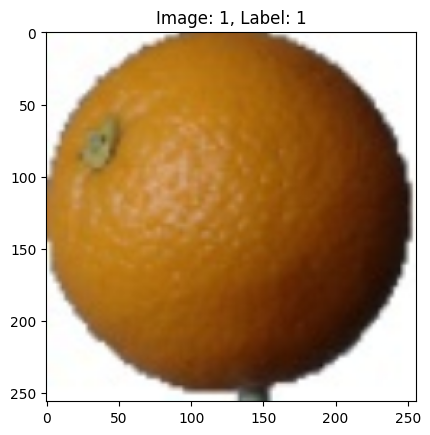

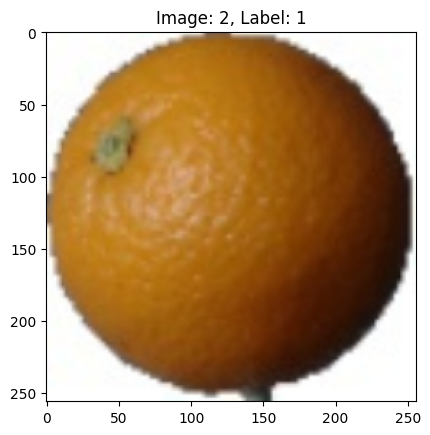

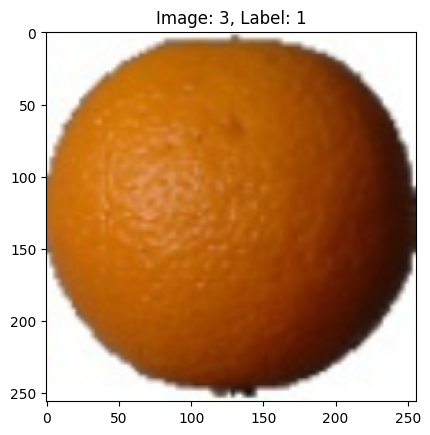

In [169]:
import matplotlib.pyplot as plt

for i in range(3):  
    img, label = custom_train_data[i]

    img = img.numpy().transpose((1, 2, 0))  

    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label}")
    plt.show()

In [170]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(32*6*6, 256)
        self.linear2 = nn.Linear(256, num_classes)
        

    def forward(self, x):
        # x - (batch, 3, 256, 256)
        out = self.conv1(x) # (batch, 8, 254, 254)
        out = F.relu(out)
        
        out = self.conv2(out) # (batch, 16, 252, 252)
        out = F.relu(out)
        
        out = self.pool1(out) # (batch, 16, 126, 126)
        
        out = self.conv3(out) # (batch, 32, 124, 124)
        out = F.relu(out)
        
        out = self.pool2(out) # (batch, 32, 62, 62)
        
        out = self.conv4(out) # (batch, 32, 60, 60)
        out = F.relu(out)
        
        out = self.pool3(out) # (batch, 32, 30, 30)
        
        out = self.conv5(out) # (batch, 32, 28, 28)
        out = F.relu(out)
        
        out = self.pool4(out) # (batch, 32, 14, 14)
        
        out = self.conv6(out) # (batch, 32, 12, 12)
        out = F.relu(out)
        
        out = self.pool5(out) # (batch, 32, 6, 6)
        
        out = self.flatten(out) # (batch, 32*6*6)
        
        out = self.linear1(out)
        out = F.relu(out)

        out = self.linear2(out)
        #out = F.softmax(out, dim=-1)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = FractureClassifier(len(train_data.classes)).to(device)
model


FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=33, bias=True)
)

In [171]:
!pip install -q torchsummary

In [172]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 252, 252]           1,168
         MaxPool2d-3         [-1, 16, 126, 126]               0
            Conv2d-4         [-1, 32, 124, 124]           4,640
         MaxPool2d-5           [-1, 32, 62, 62]               0
            Conv2d-6           [-1, 32, 60, 60]           9,248
         MaxPool2d-7           [-1, 32, 30, 30]               0
            Conv2d-8           [-1, 32, 28, 28]           9,248
         MaxPool2d-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 12, 12]           9,248
        MaxPool2d-11             [-1, 32, 6, 6]               0
          Flatten-12                 [-1, 1152]               0
           Linear-13                  [-1, 256]         295,168
           Linear-14                   

In [173]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [174]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):


    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

      

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

   

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [175]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=FractureClassifier, opt=Adam(lr=0.001000), epochs=10, device=cpu



KeyboardInterrupt: 